## 前饋神經網路(Feed-Forward Neural Network, FFNN)

## 實作練習

### 資料集說明

使用Kaggle上的Digit Recognizer練習運用神經網路進行圖像辨識  
共有42000筆資料，每筆資料代表一張28 x 28的灰階影像資料

輸入特徵：
- pixel0 ~ pixel783 (每張圖的像素值)  

輸出結果：
- label (是0 ~ 9哪一張圖像)

In [3]:
#1 讀取資料集
import pandas as pd 

train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

### 觀察資料集

先來觀察一下資料集的：
1. 輸出類別分布狀況
2. 輸入陣列數值型態
3. 輸入特徵圖像型態

<Axes: xlabel='label', ylabel='count'>

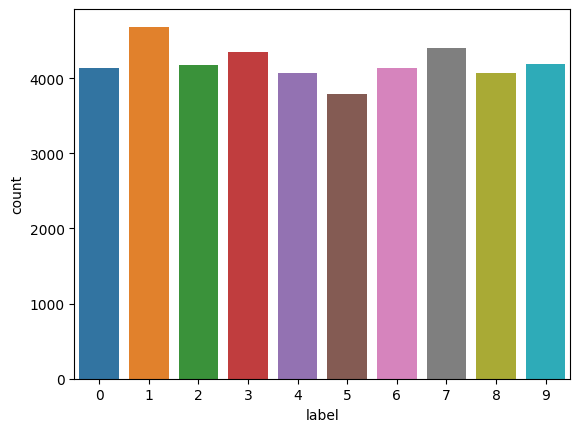

In [4]:
#2 確認各類別數量
import seaborn as sns

sns.countplot(x=train['label'] )

In [5]:
#3 觀察陣列數值型態
import numpy as np

# 提取第一列的資料
data_1d = train.iloc[0, 1:].to_numpy()
data_2d = data_1d.reshape(28, 28)

# 顯示原始型態(圖像陣列)
np.set_printoptions(linewidth=300)
print(data_2d)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 188 255  94   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 191 250 253  93   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 123 248 253 167  10   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  80 247 253 208  13   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  29 207 253 23

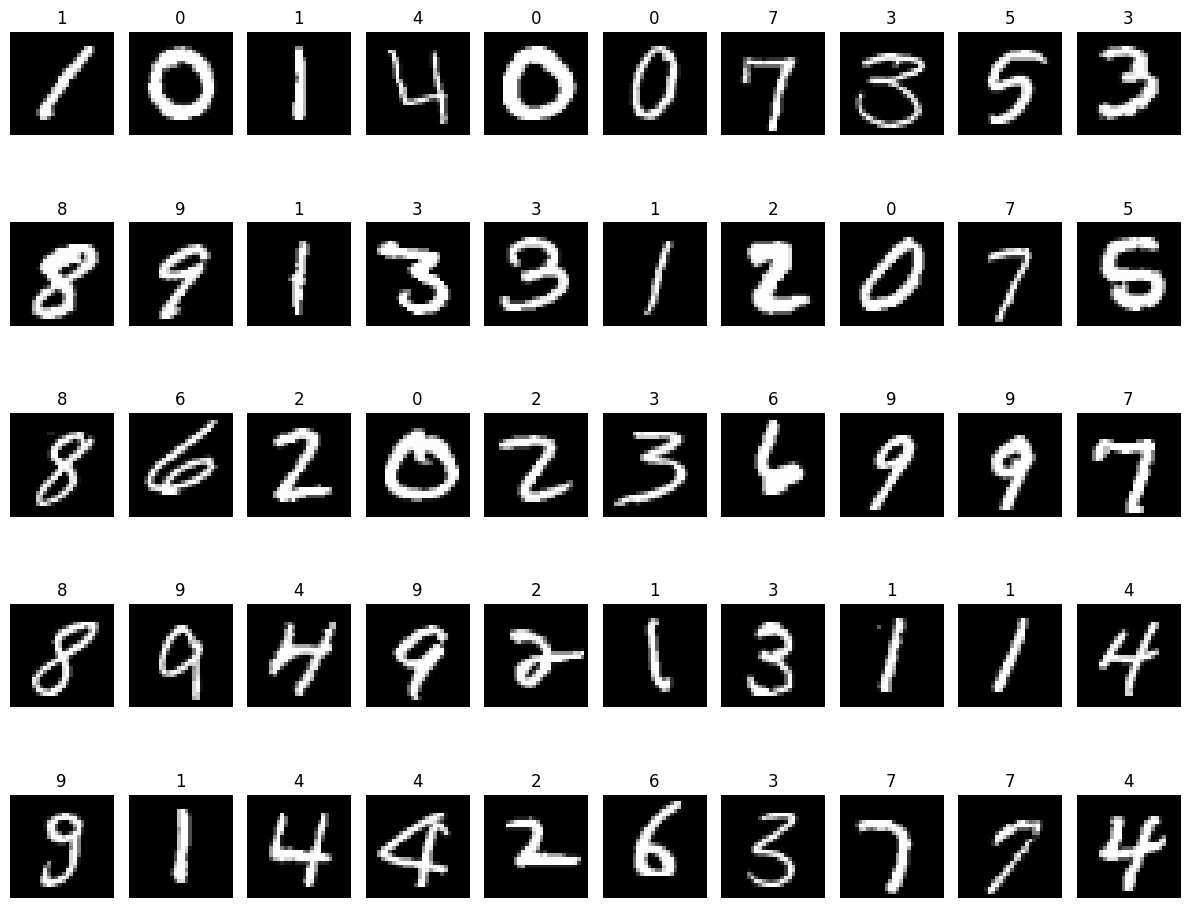

In [6]:
#4 觀察輸入圖像型態
import matplotlib.pyplot as plt
%matplotlib inline

# 繪製前50張
plt.figure(figsize=(12,10))

x, y = 10, 5
for i in range(50):
    pixels = train.iloc[i, 1:].to_numpy().reshape(28, 28)
    plt.subplot(y, x, i + 1)
    plt.imshow(pixels, cmap='gray')
    plt.axis('off')
    plt.title(train.iloc[i, 0])
    
plt.tight_layout()
plt.show()

觀察完以後發現：
1. 資料分布蠻平均的，沒有特別偏向某一類
2. pixel的資料數值應介在0 ~ 255之間
3. 手寫數字有些真的好飄逸

### 資料預處理

觀察完以後，要針對pixel和label進行以下處理：
1. 分割資料集
2. 將pixel縮放到0 ~ 1.0的範圍中
3. 將label進行編碼

備註：
- 由於我們想要使用Sigmoid作為激活函數，其中Sigmoid的domain雖然是整個實數軸，但有效範圍大約只有 \[-4, 4] (超出此範圍的值變化很小)，所以才需要將pixel / 255來將其縮放到0 ~ 1.0的範圍內，方便判斷結果

In [7]:
#5 分割資料集
from sklearn.model_selection import KFold

# 提取輸入特徵 X和輸出結果 y
train_X = train.drop(['label'], axis=1)
train_y = train['label']

# 用K-fold把資料分割成4部分用於交叉驗證
kf = KFold(n_splits=4, shuffle=True, random_state=123)

# 分割並取得資料 (tr為訓練資料, va為驗證資料)
tr_idx, va_idx = list(kf.split(train_X))[0]

tr_x, va_x = train_X.iloc[tr_idx], train_X.iloc[va_idx]
tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

In [8]:
#6 縮放pixel
tr_x, va_x = np.array(tr_x / 255.0), np.array(va_x / 255.0)

In [9]:
#7 將label編碼
from tensorflow.keras.utils import to_categorical

# 使用One-hot encoding編碼(長度為10)
tr_y = to_categorical(tr_y, 10)
va_y = to_categorical(va_y, 10)

# 查看訓練和驗證資料的形狀
print(tr_x.shape)
print(tr_y.shape)
print(va_x.shape)
print(va_y.shape)

2025-05-10 10:18:36.377769: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746872316.605419      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746872316.666744      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


(31500, 784)
(31500, 10)
(10500, 784)
(10500, 10)


現在原始的42000筆資料被拆成訓練 : 驗證 = 7.5 : 2.5的兩筆資料  
每筆資料的輸入特徵數 (pixel) 同樣是784；輸出類別數 (數字0 ~ 9) 同樣為10

### 建立Layer

接著分別建立第1層 (隱藏層) 和第2層 (輸出層)  
分別使用Sigmoid和Softmax函數作為激活函數

In [10]:
#8 建立Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input

# 先建立Sequential object
model = Sequential()

# 第1層 (神經元數量=128, 輸入形狀和tr_x相同, 激活函數為Sigmoid)
model.add(Input(shape=(tr_x.shape[1],)))
model.add(Dense(128, activation='sigmoid'))

# 第2層 (神經元數量=10, 激活函數為Softmax)
model.add(Dense(10, activation='softmax'))

I0000 00:00:1746872329.668326      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746872329.668966      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


接著要處理的是反向傳播的部分

### 設定模型的學習方式

這裡是多元分類任務，且輸出為one-hot編碼，所以選擇categorical crossentropy作為損失函數

In [11]:
#9 設定模型學習方式
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
# 輸出模型結構
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

其中dense表示第1層 (隱藏層)，目前沒有輸入，所以輸出矩陣大小為(None, 128)  
而參數數量100480 = 784(pixel數量) $\times$ 128(神經元數量) + 128(偏值數量)

### 訓練模型

建立好雙層神經網路後，就用資料集來進行訓練

In [12]:
#10 訓練模型
# 設定迭代次數=5, 一批為100個資料
result = model.fit(tr_x, tr_y, epochs=5, batch_size=100, 
                   validation_data=(va_x, va_y), verbose=1)

Epoch 1/5


I0000 00:00:1746872332.343322      97 service.cc:148] XLA service 0x798b1c00fab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746872332.344189      97 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746872332.344209      97 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746872332.513149      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


120/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5710 - loss: 1.6540

I0000 00:00:1746872333.293503      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7103 - loss: 1.1989 - val_accuracy: 0.9000 - val_loss: 0.3896
Epoch 2/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9064 - loss: 0.3536 - val_accuracy: 0.9177 - val_loss: 0.2937
Epoch 3/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9217 - loss: 0.2748 - val_accuracy: 0.9270 - val_loss: 0.2538
Epoch 4/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9339 - loss: 0.2365 - val_accuracy: 0.9343 - val_loss: 0.2271
Epoch 5/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9402 - loss: 0.2117 - val_accuracy: 0.9398 - val_loss: 0.2083


先來看看訓練結果

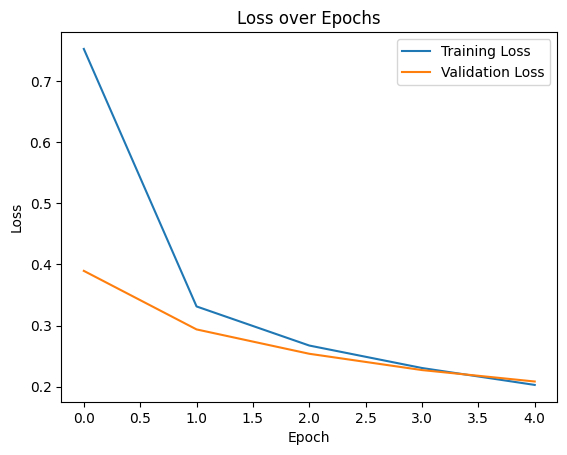

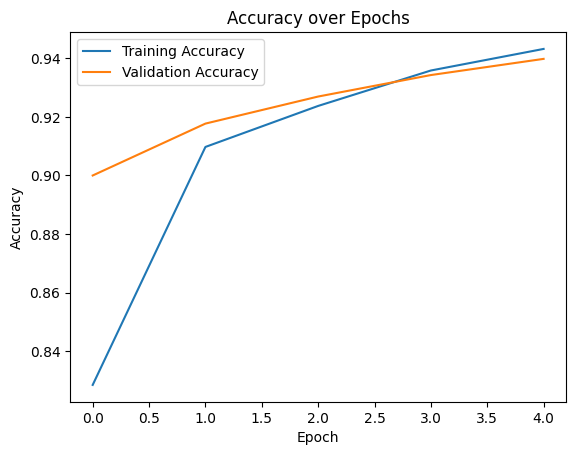

In [13]:
#11 觀察訓練集與驗證集的結果
# loss function變化圖
plt.plot(result.history['loss'], label='Training Loss')
plt.plot(result.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 準確率變化圖
plt.plot(result.history['accuracy'], label='Training Accuracy')
plt.plot(result.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
#12 測試模型
result = model.predict(test)

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


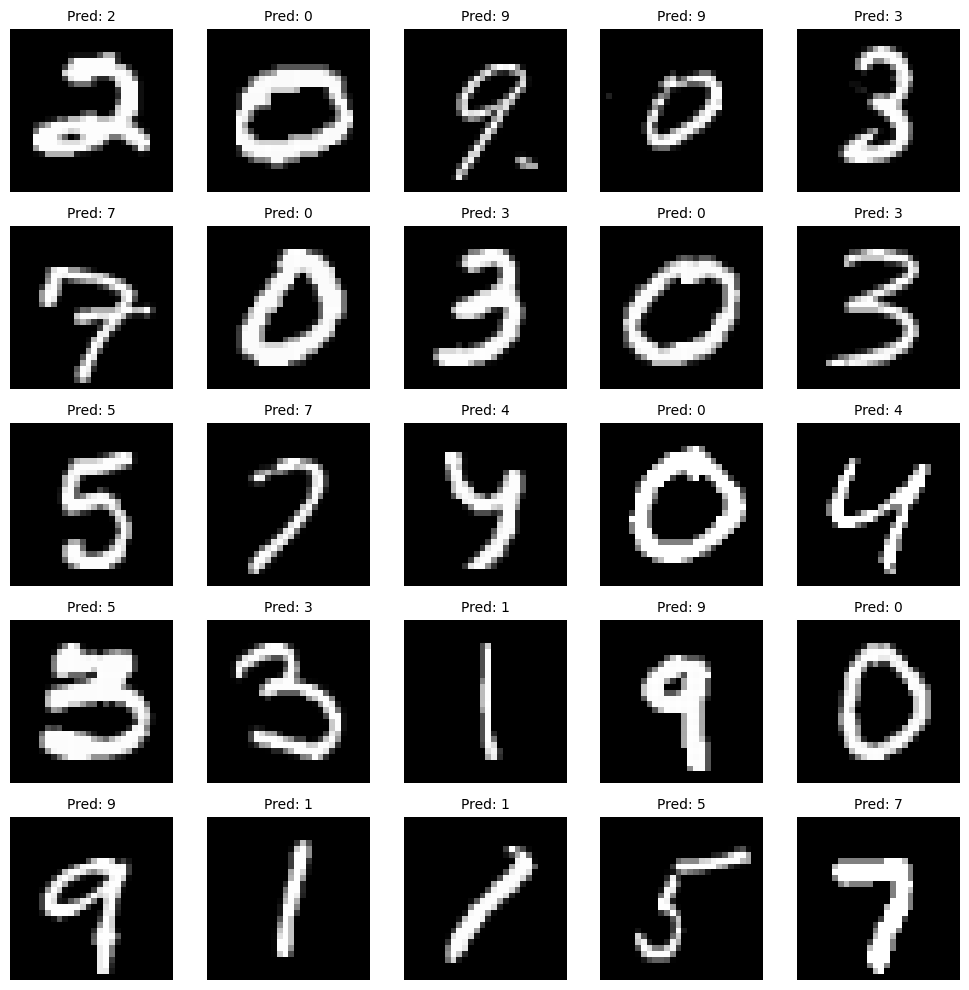

In [15]:
#13 查看測試結果
# 顯示前25筆資料預測結果
plt.figure(figsize=(10, 10))
y_test_pred = np.argmax(result, axis=1)

for i in range(25):
    pixels = test.iloc[i].to_numpy().reshape(28, 28)
    
    plt.subplot(5, 5, i + 1) 
    plt.imshow(pixels, cmap='gray')
    plt.title(f"Pred: {y_test_pred[i]}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [16]:
#14 儲存結果
submission = pd.DataFrame({
    'ImageId': np.arange(1, len(y_test_pred) + 1),
    'Label': y_test_pred
})

submission.to_csv('submission.csv', index=False)